In [23]:
import keras
import numpy as np
import tensorflow as tf
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import tempfile
import sys
import time
import os

print("环境准备完成")

环境准备完成


## 数据集加载 

In [24]:
def load_data_fashion_mnist(mnist_train, mnist_test, batch_size):
    if sys.platform.startswith('win'):
        num_workers = 0
    else:
        num_workers = 4
    train_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter

## 加载数据集、参数设置 

In [25]:
# 使用临时目录
with tempfile.TemporaryDirectory() as tmpdirname:
    train_loader = DataLoader(
        datasets.FashionMNIST(
            root=tmpdirname, 
            train=True, 
            transform=transforms.ToTensor(), 
            download=True
        ), 
        batch_size=64, 
        shuffle=True
    )
    test_loader = DataLoader(
        datasets.FashionMNIST(
            root=tmpdirname, 
            train=False, 
            transform=transforms.ToTensor(), 
            download=True
        ), 
        batch_size=64, 
        shuffle=False
    )

    mnist_train = torchvision.datasets.FashionMNIST(
        root=tmpdirname, 
        train=True, 
        download=True, 
        transform=transforms.ToTensor()
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root=tmpdirname, 
        train=False, 
        download=True, 
        transform=transforms.ToTensor()
    )

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


batch_size = 64
train_iter, test_iter = load_data_fashion_mnist(mnist_train, mnist_test, batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_dir = 'results/process_picture/'
weight_dir = 'results/weight/'

#训练参数
lr, num_epochs = 0.001, 3

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /tmp/tmpzjmks6ag/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/tmpzjmks6ag/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /tmp/tmpzjmks6ag/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/tmpzjmks6ag/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /tmp/tmpzjmks6ag/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/tmpzjmks6ag/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /tmp/tmpzjmks6ag/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/tmpzjmks6ag/FashionMNIST/raw



## 训练函数 

In [26]:
def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    train_loss_list, train_acc_list, test_acc_list = [], [], []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        train_loss_list.append(train_l_sum / batch_count)
        train_acc_list.append(train_acc_sum / n)
        test_acc_list.append(test_acc)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    return train_loss_list, train_acc_list, test_acc_list

## 效果分析函数 

In [27]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train() # 改回训练模式
            n += y.shape[0]
    return acc_sum / n

## 训练过程可视化 

In [28]:
def train_process(num_epochs, train_loss_list, train_acc_list, test_acc_list,save_name):
    # 绘制训练过程的损失和准确率
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_list, label='Training accuracy')
    plt.plot(epochs, test_acc_list, label='Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)

    # 生成文件路径
    file_path = os.path.join(save_dir, save_name)

    # 保存图片
    plt.savefig(file_path)
    plt.show()

    print(f'Plot saved to {file_path}')

### 搭建全连接神经网络 

#### 网络搭建 

In [29]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### 编译神经网络并开始训练

In [30]:
# 实例化网络
network = Network()
loss_func = nn.CrossEntropyLoss()
# 设置优化器
optimizer = optim.SGD(network.parameters(), lr=0.01)

# 训练网络
loss_list = []
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = network(images)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_list.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Epoch 1/3, Loss: 1.4069
Epoch 2/3, Loss: 0.7295
Epoch 3/3, Loss: 0.6054


#### 可视化训练过程 

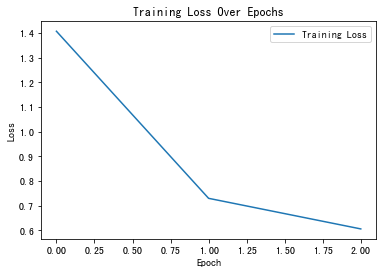

Plot saved to results/process_picture/FC.png


In [31]:
# 可视化训练损失
plt.plot(loss_list, label='Training Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 创建保存目录
os.makedirs(save_dir, exist_ok=True)


# 生成文件路径
file_path = os.path.join(save_dir, 'FC.png')

# 保存图片
plt.savefig(file_path)

plt.show()

print(f'Plot saved to {file_path}')

#### 保存模型 

In [32]:
weight_path = os.path.join(weight_dir,'FC_mnist.pth')
torch.save(network,weight_path)

### 搭建LeNET卷积神经网络 

#### 网络搭建 

In [21]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

#网络实例化
lenet = LeNet()

#### 开始训练 

In [24]:
optimizer = torch.optim.Adam(lenet.parameters(), lr=lr)
train_loss_list, train_acc_list, test_acc_list = train(lenet, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.6897, train acc 0.737, test acc 0.744, time 9.2 sec


KeyboardInterrupt: 

#### 可视化训练过程 

In [25]:
train_process(num_epochs,train_loss_list,train_acc_list,test_acc_list,'LeNet.png')

NameError: name 'train_loss_list' is not defined

#### 保存模型 

In [ ]:
weight_path = os.path.join(weight_dir,'LeNET_mnist.pth')
torch.save(lenet,weight_path)

### 搭建AlexNET卷积神经网络 

#### 网络搭建 

In [26]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),  # 1 通道改为 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        output = self.classifier(x)
        return output
    
#网络实例化
alexnet = AlexNet()

#### 开始训练 

In [27]:
optimizer = torch.optim.Adam(alexnet.parameters(), lr=lr)
train_loss_list, train_acc_list, test_acc_list = train(alexnet, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.5492, train acc 0.792, test acc 0.869, time 15.1 sec


KeyboardInterrupt: 

#### 可视化训练过程 

In [ ]:
train_process(num_epochs,train_loss_list,train_acc_list,test_acc_list,'AlexNet.png')

#### 保存训练结果

In [ ]:
weight_path = os.path.join(weight_dir,'Alexnet_mnist.pth')
torch.save(alexnet,weight_path)

### 搭建VggNet卷积神经网络 

#### 网络搭建 

In [29]:
# 定义简化的 VGG 网络
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
#网络实例化
vggnet = VGGNet()

####  开始训练

In [30]:
optimizer = torch.optim.Adam(vggnet.parameters(), lr=lr)
train_loss_list, train_acc_list, test_acc_list = train(vggnet, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.6182, train acc 0.762, test acc 0.848, time 27.7 sec


KeyboardInterrupt: 

#### 训练过程可视化 

In [31]:
train_process(num_epochs,train_loss_list,train_acc_list,test_acc_list,'VggNet.png')

NameError: name 'train_loss_list' is not defined

#### 保存模型 

In [32]:
weight_path = os.path.join(weight_dir,'vggnet_mnist.pth')
torch.save(vggnet,weight_path)

### 搭建resnet卷积神经网络 

#### 网络搭建

In [34]:
# 定义基本的残差块
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion * 4 * 4, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out
    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

resnet = ResNet18().to(device)

#### 开始训练 

In [35]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)
train_loss_list, train_acc_list, test_acc_list = train(resnet, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.5200, train acc 0.831, test acc 0.882, time 55.8 sec


KeyboardInterrupt: 

#### 训练过程可视化 

In [36]:
train_process(num_epochs,train_loss_list,train_acc_list,test_acc_list,'ResNet.png')

NameError: name 'train_loss_list' is not defined

#### 保存模型

In [ ]:
weight_path = os.path.join(weight_dir,'resnet_mnist.pth')
torch.save(resnet,weight_path)

### 搭建DenseNet卷积神经网络 

#### 网络搭建 

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(torch.relu(self.bn1(x)))
        out = self.conv2(torch.relu(self.bn2(out)))
        out = torch.cat([out, x], 1)
        return out

class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(torch.relu(self.bn(x)))
        out = nn.functional.avg_pool2d(out, 2)
        return out

class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2 * growth_rate
        self.conv1 = nn.Conv2d(1, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0] * growth_rate
        self.trans1 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1] * growth_rate
        self.trans2 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2] * growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(1536, num_classes)
  # 修改全连接层输入维度

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for _ in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        # print("Input shape:", x.shape)
        out = self.conv1(x)
        # print("After Conv1:", out.shape)
        out = self.trans1(self.dense1(out))
        # print("After Dense1 and Trans1:", out.shape)
        out = self.trans2(self.dense2(out))
        # print("After Dense2 and Trans2:", out.shape)
        out = self.dense3(out)
        # print("After Dense3:", out.shape)
        out = torch.relu(self.bn(out))
        out = nn.functional.avg_pool2d(out, 3)
        # print("After final avg pool:", out.shape)
        out = out.view(out.size(0), -1)
        # print("Before Linear:", out.shape)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6, 12, 24], growth_rate=12)

densenet = DenseNet121().to(device)

#### 开始训练 

In [38]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=lr)
train_loss_list, train_acc_list, test_acc_list = train(densenet, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.3751, train acc 0.861, test acc 0.889, time 70.3 sec


KeyboardInterrupt: 

#### 训练过程可视化

In [ ]:
train_process(num_epochs,train_loss_list,train_acc_list, test_acc_list,'DenseNet.png')

#### 保存模型 

In [ ]:
weight_path = os.path.join(weight_dir,'densenet_mnist.pth')
torch.save(densenet,weight_path)